# Investigating MASH logBF computation under EE model

This is a continuation of a [previous investigation](https://gaow.github.io/mvarbvs/analysis/20191204_Diagnosis.html).

## Load package and previous results

Previous result can be [downloaded here](https://github.com/gaow/mmbr/files/3935471/issue_9_EE_sumstats.tar.gz). `good_lbf` in this dataset saves `lbf` from `mmbr:::BayesianMultivariateRegression`.

In [1]:
devtools::load_all('/home/gaow/GIT/software/mashr')

Loading mashr
Loading required package: ashr


In [2]:
setwd('/home/gaow/tmp/07-Dec-2019')
dat = readRDS('issue_9_EE_sumstats.rds')

## Set data

In [3]:
mash_data = mash_set_data(dat$bhat, dat$sbhat, V=dat$V, alpha=0)

In [4]:
names(mash_data)

[1] "Bhat"       "Shat"       "Shat_alpha" "V"          "commonV"   
[6] "alpha"

## Compare loglik

In [5]:
r1 = calc_relative_lik_matrix(mash_data,dat$xUlist, algorithm.version = 'Rcpp')

In [6]:
r2= calc_relative_lik_matrix(mash_data,dat$xUlist, algorithm.version = 'R')

In [7]:
names(r1)

[1] "loglik_matrix" "lfactors"

In [8]:
expect_equal(r1$lfactors, r2$lfactors)

In [9]:
expect_equal(r1$loglik_matrix, r2$loglik_matrix)

Loglik computations are okay.

## Compare posterior

In [10]:
posterior_weights <- compute_posterior_weights(dat$pi_s,exp(r1$loglik_matrix))

In [11]:
p1 <- compute_posterior_matrices(mash_data, dat$xUlist, posterior_weights, algorithm.version="Rcpp")

In [12]:
p2 <- compute_posterior_matrices(mash_data, dat$xUlist, posterior_weights, algorithm.version="R")

In [13]:
names(p1)

[1] "PosteriorMean" "PosteriorSD"   "lfdr"          "NegativeProb" 
[5] "lfsr"

In [14]:
expect_equal(p1$PosteriorMean, p2$PosteriorMean)

In [15]:
expect_equal(p1$PosteriorSD, p2$PosteriorSD)

In [16]:
expect_equal(p1$lfdr, p2$lfdr)

In [17]:
expect_equal(p1$NegativeProb, p2$NegativeProb)

In [18]:
expect_equal(p1$lfsr, p2$lfsr)

Posterior calculations also are consistent between R and Rcpp versions.

## LBF calculations

In [19]:
null_loglik = compute_null_loglik_from_matrix(r1,mash_data$Shat_alpha)
alt_loglik = compute_alt_loglik_from_matrix_and_pi(dat$pi_s,r1,mash_data$Shat_alpha)

In [20]:
lbf = alt_loglik-null_loglik

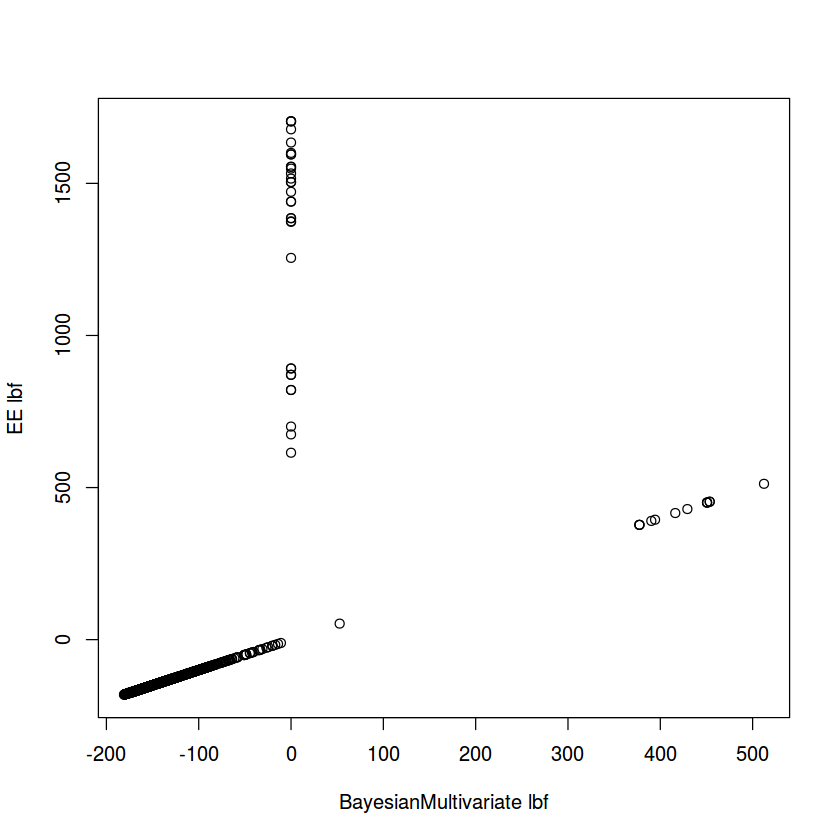

In [21]:
plot(dat$good_lbf, lbf, xlab="BayesianMultivariate lbf", ylab = "EE lbf")

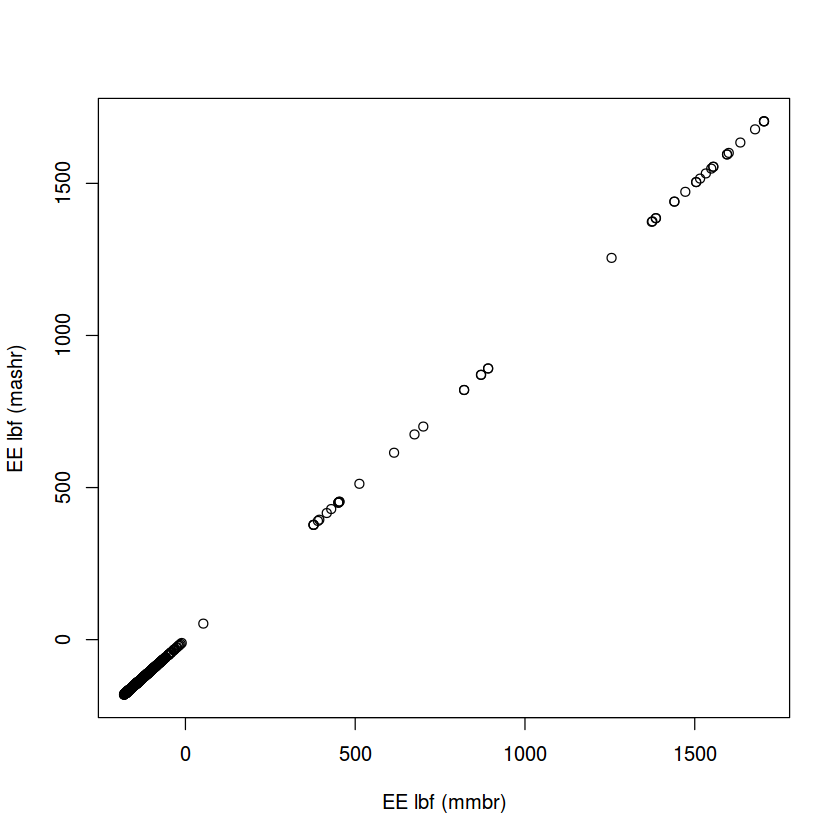

In [22]:
plot(dat$bad_lbf, lbf, xlab="EE lbf (mmbr)", ylab = "EE lbf (mashr)")

lbf indeed agrees with what `mmbr:::MashRegression` gives, not consistent with what `BayesianMultivariateRegression` says.

Let's see what the loglik matrix tells us about these zero BF's,

In [23]:
(r1$loglik_matrix + r1$lfactors)[which(lbf>1000),]

-1579.044,16.10435
-1687.964,16.01919
-1579.044,16.10435
-1687.964,16.01919
-1687.964,16.01919
-1618.209,16.08220
-1532.376,16.20638
-1661.609,16.06732
-1499.532,16.22189
-1516.505,16.20907
-1584.056,16.14898


In [24]:
head((r1$loglik_matrix + r1$lfactors)[which(abs(lbf)<50),])

48.75543,17.76282
31.86381,17.76036
28.63014,17.67223
37.62594,17.69075
44.40809,17.70641
52.48401,17.75334


It seems the loglik for null was wrong from the beginning. The reason `mmbr:::BayesianMultivariateRegression` does not have the issue is [because it avoids numerical issues](https://github.com/gaow/mmbr/blob/44a310e3894f516629ddeb3f877c938f4fbc5733/R/bayesian_multivariate_regression.R#L88) when it tries to compute lbf, instead of using `dmvnorm()`.

And indeed, if I [uncomment this line](https://github.com/gaow/mmbr/blob/44a310e3894f516629ddeb3f877c938f4fbc5733/R/bayesian_multivariate_regression.R#L90) using `dmvnorm()` to compute lbf, then the result agrees with `mmbr:::MashRegression` and also wrong [for the example on this page](https://gaow.github.io/mvarbvs/analysis/20191204_Diagnosis.html).

## To reproduce the "good" lbf with summary stats

In [25]:
U = dat$xUlist[[2]]
S = lapply(1:nrow(dat$sbhat), function(j) diag(dat$sbhat[j,]) %*% dat$V %*% diag(dat$sbhat[j,]))

In [30]:
S_inv = lapply(1:length(S), function(j) solve(S[[j]]))
post_cov = lapply(1:length(S), function(j) U %*% solve(diag(nrow(U)) + S_inv[[j]] %*% U))
good_lbf = sapply(1:length(S), function(j) 0.5 * (log(det(S[[j]])) - log(det(S[[j]]+U))) + 0.5*t(dat$bhat[j,])%*%S_inv[[j]]%*%post_cov[[j]]%*%S_inv[[j]]%*%dat$bhat[j,])
good_lbf[which(is.infinite(good_lbf))] = 0

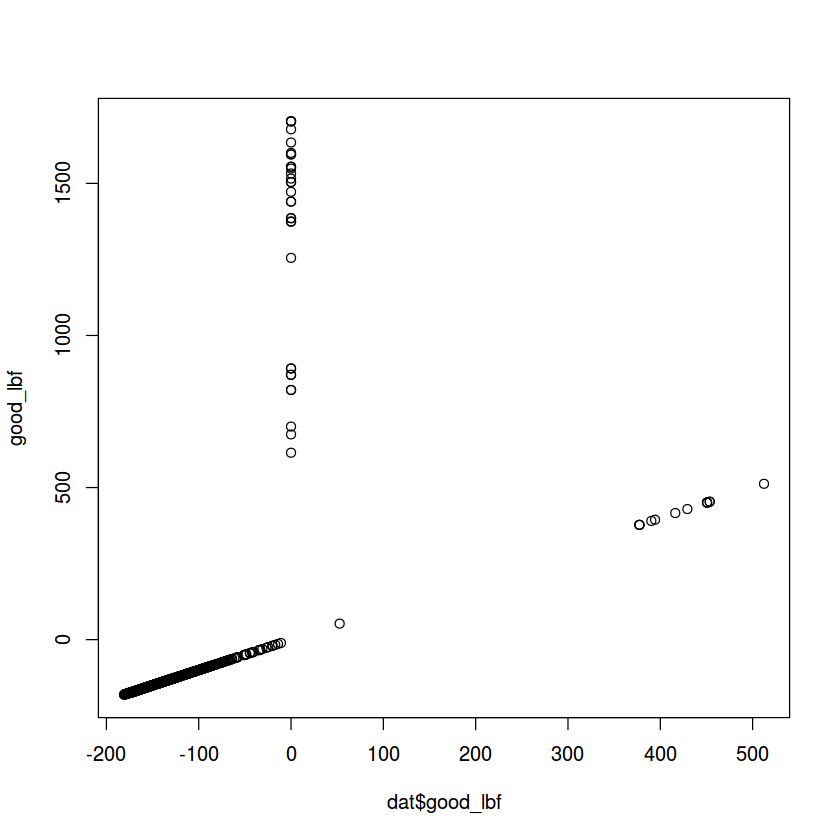

In [31]:
plot(dat$good_lbf, good_lbf)

## Conclusion

We need to solve the loglik calculation issue in `mash`, because without fixing that, the posterior weights will be wrong and that will undermine MASH model. I'll try to come up with a minimal example vignette to post on `mashr` github.

## Update

Yuxin pointed to me, after she looked at the data, that if I dont set `infinity` to zero but work instead at log scale I will be getting the same result as in EE model. Therefore I changed the mmbr code from:

```
good_lbf = log(sapply(1:length(S), function(j) sqrt(det(S[[j]])/det(S[[j]]+U))*exp(0.5*t(dat$bhat[j,])%*%S_inv[[j]]%*%post_cov[[j]]%*%S_inv[[j]]%*%dat$bhat[j,])))
```

to 


```
good_lbf = sapply(1:length(S), function(j) 0.5 * (log(det(S[[j]])) - log(det(S[[j]]+U))) + 0.5*t(dat$bhat[j,])%*%S_inv[[j]]%*%post_cov[[j]]%*%S_inv[[j]]%*%dat$bhat[j,])
```

But after the change, those `infinite` false signals which were once removed now comes back and contribute to bad lbf, leading to false positives in the results.